In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

In [2]:
data = pandas.read_csv('ad_table.csv')
data.shape

(2115, 7)

In [3]:
data.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [4]:
data['date'] = pandas.to_datetime(data['date'])
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2115.000000,2115.000000,2115.000000,2115.000000,2115.000000
mean,68299.844444,3056.077069,126.453901,1.373749,1966.517589
std,48884.821409,3783.579969,233.420826,0.754331,3942.018757
min,0.000000,0.000000,0.000000,0.000000,-200.150000
25%,28030.500000,744.000000,18.000000,0.760000,235.470000
50%,54029.000000,1392.000000,41.000000,1.400000,553.300000
75%,97314.500000,3366.500000,103.000000,1.920000,1611.495000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


In [5]:
# clean the negative revenue
len(data.query('total_revenue<0'))

4

In [6]:
data = data.query('total_revenue >= 0')

In [7]:
len(data.query('shown<clicked | clicked<converted'))

0

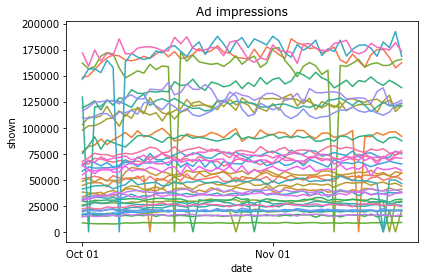

In [8]:
g = sns.lineplot(x='date',y='shown',hue='ad',data=data,legend='')
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title('Ad impressions')
plt.show()

In [9]:
# remove zero impressiondata
data = data.query('shown>0')

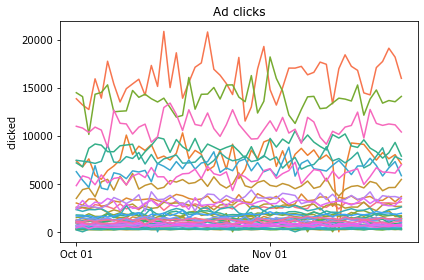

In [10]:
g = sns.lineplot(x='date',y='clicked',hue='ad',data=data,legend='')
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title('Ad clicks')
plt.show()

In [11]:
# remove zero click data
data = data.query('clicked>0')

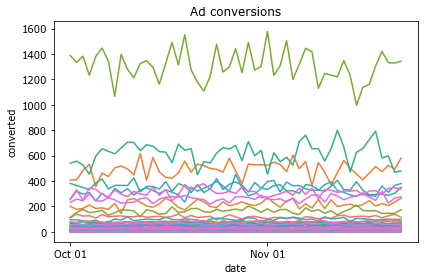

In [12]:
g = sns.lineplot(x='date',y='converted',hue='ad',data=data,legend='')
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title('Ad conversions')
plt.show()

In [13]:
data.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,68853.852702,3088.744142,127.822573,1.387661,1989.242257
std,48799.535713,3792.468317,234.394500,0.746035,3958.838731
min,7494.000000,187.000000,0.000000,0.080000,0.000000
25%,28446.000000,756.500000,18.000000,0.780000,244.765000
50%,54569.000000,1413.000000,42.000000,1.410000,561.070000
75%,100395.500000,3413.500000,106.000000,1.920000,1634.895000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


In [14]:
# CTR and profit per ad group
data_rank = data.groupby('ad').apply(lambda x:pandas.Series({
    'CTR': (x['clicked']/x['shown']).mean(),
    'profits': (x['total_revenue']-x['clicked']*x['avg_cost_per_click']).mean(),
    'count': x['shown'].mean()
})).reset_index()
data_rank['count'].min()

8461.096153846154

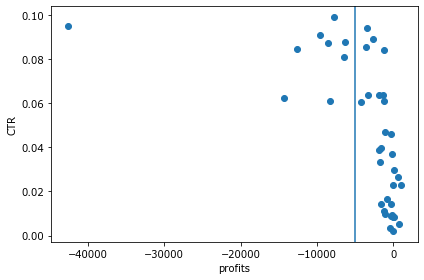

In [15]:
plt.scatter(data_rank['profits'], data_rank['CTR'])
plt.axvline(x=-5000)
plt.xlabel('profits')
plt.ylabel('CTR')
plt.show()

In [16]:
data_rank.query('profits>-5000').sort_values('CTR',ascending=False).head(5)

,ad,CTR,profits,count
10,ad_group_19,0.094188,-3460.419038,19506.884615
20,ad_group_28,0.089191,-2644.280943,19886.339623
4,ad_group_13,0.085635,-3573.196275,161519.176471
27,ad_group_34,0.084257,-1189.270000,35371.622642
35,ad_group_5,0.063862,-3233.796538,52406.461538


In [19]:
import fbprophet

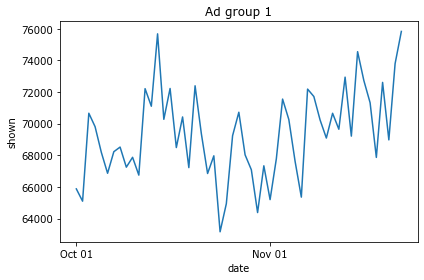

In [20]:
data_ad1 = data.query('ad==\"ad_group_1\"')[["date", "shown"]]
g = sns.lineplot(x="date", y="shown", data=data_ad1)
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title('Ad group 1')
plt.show()

In [21]:
# build time series using prophet
data_ad1['ds'] = data_ad1['date']
data_ad1.rename({'shown':'y'}, axis=1, inplace=True)
data_ad1.set_index('date', inplace=True)

In [22]:
ts = fbprophet.Prophet()
ts.fit(data_ad1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
# make predictions until Dec 15
days_predictions = (pandas.to_datetime("2015-12-15")-data_ad1['ds'].max()).days
future_data = ts.make_future_dataframe(periods = days_predictions)
predictions = ts.predict(future_data)

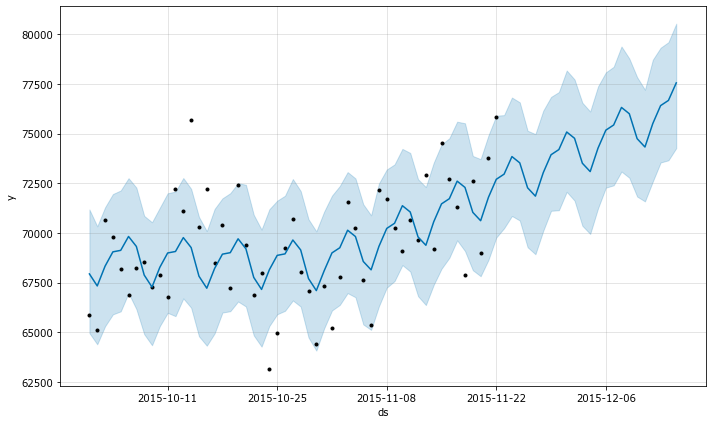

In [24]:
ts.plot(predictions)
plt.show()

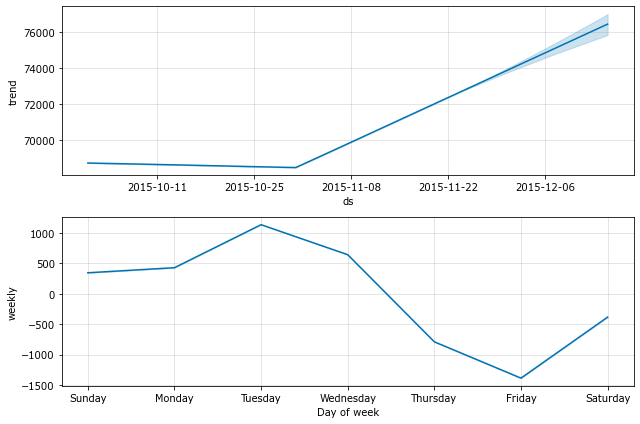

In [26]:
# plot series component
ts.plot_components(predictions)
plt.show()

In [29]:
# get the predictions for all the ad groups
predictions_all_groups = pandas.DataFrame({'ad_group': data['ad'].unique(),
                                          'date': pandas.to_datetime('2015-12-15')})
predictions_dec_15 = []

In [31]:
for level in predictions_all_groups.ad_group:
    # subset data with ad group
    tmp = data.loc[data['ad']==level][['date','shown']]
    # change column names and index
    tmp['ds'] = tmp['date']
    tmp.rename({'shown': 'y'}, axis=1, inplace=True)
    tmp.set_index('date', inplace=True)
    # build the model
    ts_tmp = fbprophet.Prophet()
    ts_tmp.fit(tmp)
    # make prediction until Dec 15
    days_predictions_tmp = (pandas.to_datetime('2015-12-15')-tmp['ds'].max()).days
    future_data_tmp = ts_tmp.make_future_dataframe(periods = days_predictions_tmp)
    predictions_tmp = ts_tmp.predict(future_data_tmp)
    # store results for Dec 15 prediction
    predictions_dec_15.append(round(predictions_tmp['yhat'].iat[-1]))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [32]:
predictions_all_groups['predictions'] = predictions_dec_15
predictions_all_groups

,ad_group,date,predictions
0,ad_group_1,2015-12-15,77558
1,ad_group_2,2015-12-15,50305
2,ad_group_3,2015-12-15,152888
3,ad_group_4,2015-12-15,94679
4,ad_group_5,2015-12-15,54750
5,ad_group_6,2015-12-15,40587
6,ad_group_7,2015-12-15,56988
7,ad_group_8,2015-12-15,47171
8,ad_group_9,2015-12-15,124642
9,ad_group_10,2015-12-15,127043


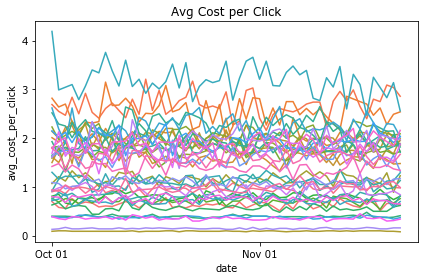

In [33]:
# plot cost_per_click vs date
g = sns.lineplot(x='date', y='avg_cost_per_click', hue='ad', data=data, legend='')
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
g.set_title('Avg Cost per Click')
plt.show()

In [34]:
import statsmodels.api as sm

In [44]:
# build all linear regressions
coefficient = []
p_value = [] 

In [45]:
for level in data['ad'].unique():
    data_reg = data.loc[data['ad']==level][['date','avg_cost_per_click']]
    # replace dates with numbers and add intercept
    data_reg['date'] = (data_reg['date'] - data_reg['date'].min()).dt.days
    data_reg['intercept'] = 1
    # build the regression
    lr = sm.OLS(data_reg['avg_cost_per_click'], data_reg.drop('avg_cost_per_click', axis=1)).fit()
    # save coefficient and p-value
    coefficient.append(lr.params[0])
    p_value.append(lr.pvalues[0])

In [46]:
lr_output = pandas.DataFrame({'ad_group': data['ad'].unique(),
                              'coefficients': coefficient,
                              'p_value': p_value})

In [48]:
# classify based on coefficient and use Bonferroni rule for significance
lr_output['cluster'] = np.where(lr_output['p_value'] > 0.05/40, 'flat',
                                np.where(lr_output['coefficients'] < 0, 'going_down', 'going_up'))

In [49]:
lr_output

,ad_group,coefficients,p_value,cluster
0,ad_group_1,0.000926,0.145429,flat
1,ad_group_2,-0.000006,0.991095,flat
2,ad_group_3,0.002445,0.255564,flat
3,ad_group_4,-0.000577,0.804445,flat
4,ad_group_5,-0.001018,0.440261,flat
5,ad_group_6,-0.001734,0.077129,flat
6,ad_group_7,-0.002569,0.120068,flat
7,ad_group_8,-0.002689,0.026231,flat
8,ad_group_9,0.000044,0.434626,flat
9,ad_group_10,-0.000161,0.861238,flat


In [50]:
lr_output['cluster'].value_counts()

flat    40
Name: cluster, dtype: int64